# Time series analysis and visualization
---

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np

from pandas_datareader.data import DataReader
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [15, 8]

## Part 1

* It is not specified what a `period` is. In the following functions, I assume it is two strings specifying a start date and an end date.


* I am not quite sure why it is asked to interpolate missing values. There is no available data when the stock market is closed, but this is not considered as missing data, it reflects the reality of the data being studied. When using the `start` and the `end` argument of the `DataReader`, we get data for each day the market was open, without any missing values (demonstrated in the cell below). Therefore no interpolation will be used in the following methods.

In [3]:
stock = DataReader('AMZN', start='2005-01-01', end='2019-01-01', data_source='yahoo')
stock.isna().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

## Functions

In [4]:
def show_correlation(stock_name, start, end):
    stock = DataReader(stock_name, start=start, end=end, data_source='yahoo')[['Open', 'Close']]
    business_month_end = pd.date_range(start, end, freq='BM')
    month_end = stock[stock.index.isin(business_month_end)]
    sns.scatterplot(x=month_end['Open'], y=month_end['Close'])
    plt.xlabel("Opening price in $")
    plt.ylabel("Closing price in $")
    plt.title("Correlation between opening and closing prices of {} stock between {} and {}".format(stock_name, start, end))

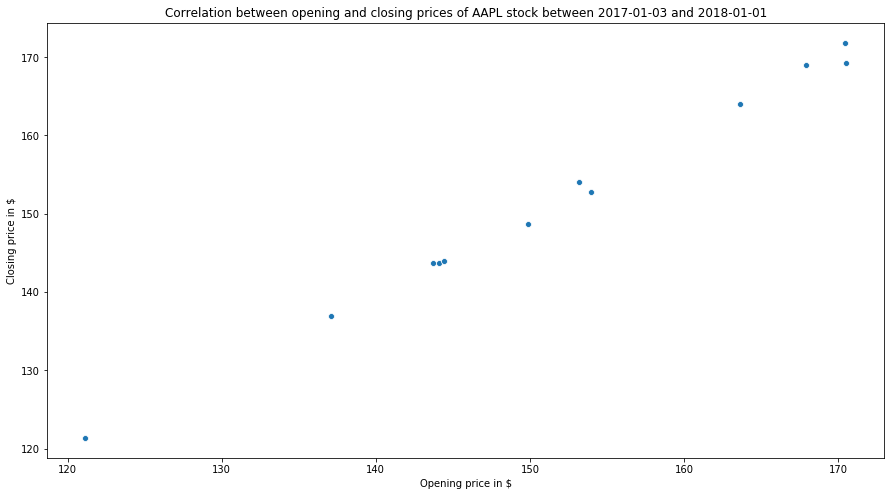

In [5]:
show_correlation('AAPL', '2017-01-03', '2018-01-01')

In [6]:
def show_daily_features(stock_name, start, end):
    stock = DataReader(stock_name, start=start, end=end, data_source='yahoo')
    fig, ax = plt.subplots(2, 2, sharex='col')
    fig.autofmt_xdate()
    fig.suptitle('Daily features of {} stock from {} to {}'.format(stock_name, start, end))
    sns.lineplot(stock.index, stock['Low'], ax=ax[0, 0])
    ax[0, 0].set(xlabel='Date', ylabel='Price in $', title='Low price evolution over time')
    sns.lineplot(stock.index, stock['High'], ax=ax[1, 0])
    ax[1, 0].set(xlabel='Date', ylabel='Price in $', title='High price evolution over time')
    stock['Open'].hist(ax=ax[0, 1], bins=20)
    ax[0, 1].set(xlabel='Price in $', ylabel='Number of occurences', title='Opening price distribution')
    stock['Close'].hist(ax=ax[1, 1], bins=20)
    ax[1, 1].set(xlabel='Price in $', ylabel='Number of occurences', title='Closing price distribution')

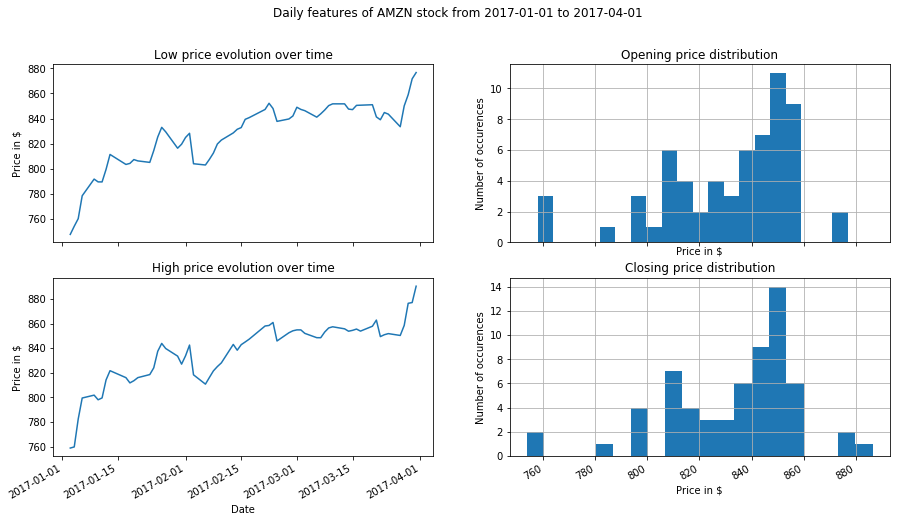

In [7]:
show_daily_features('AMZN', '2017-01-01', '2017-04-01')

In [8]:
def show_monthly_average(stock_name, start, end):
    stock = DataReader(stock_name, start=start, end=end, data_source='yahoo')[['Open', 'Close', 'High', 'Low']]
    monthly_mean = stock.groupby(pd.Grouper(freq='BM', label='left')).mean()
    sns.lineplot(data=monthly_mean['Open'], label='Open')
    sns.lineplot(data=monthly_mean['Close'], label='Close')
    sns.lineplot(data=monthly_mean['High'], label='High', color='green')
    sns.lineplot(data=monthly_mean['Low'], label='Low', color='red')
    plt.xlabel("Date")
    plt.ylabel("Monthly price average in $")
    plt.title("Evolution of opening, closing, high and low monthly mean prices of {} stock between {} and {}".format(stock_name, start, end))

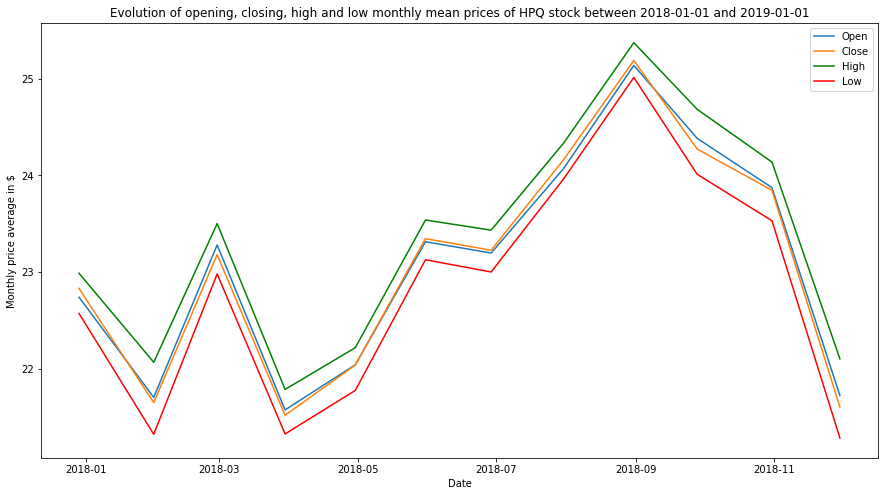

In [9]:
show_monthly_average('HPQ', '2018-01-01', '2019-01-01')

In [10]:
def line_format(label):
    return '{}\n{}'.format(label.month_name()[:3], str(label.year))

def show_stock_statistics(stock_name, start, end):
    
    stock = DataReader(stock_name, start=start, end=end, data_source='yahoo')[['Close']]
    monthly_groupby = stock.groupby(pd.Grouper(freq='BM')).agg(
        min_close=pd.NamedAgg(column='Close', aggfunc=np.min),
        mean_close=pd.NamedAgg(column='Close', aggfunc=np.mean),
        max_close=pd.NamedAgg(column='Close', aggfunc=np.max),
    )
    ax = monthly_groupby.plot.bar(color=['red', 'blue', 'green'])
    plt.grid(axis='y', linestyle='--')
    ax.set_xticklabels(map(line_format, monthly_groupby.index))
    plt.legend(['Month min', 'Month mean', 'Month max'])
    plt.xlabel("Month")
    plt.ylabel("Close price in $")
    plt.title("Evolution of min, max and mean closing prices of {} stock between {} and {}".format(stock_name, start, end))

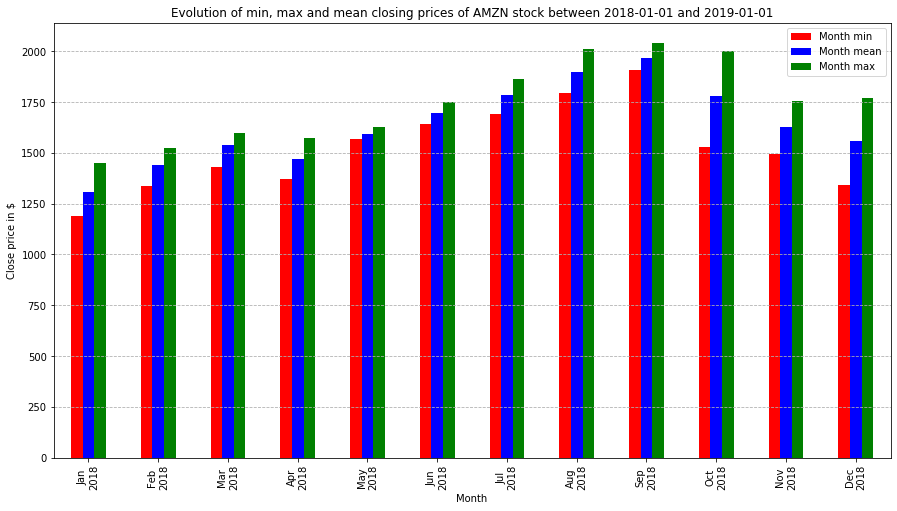

In [11]:
show_stock_statistics('AMZN', '2018-01-01', '2019-01-01')

## Part 2

In [12]:
def normalize_dataframe(df):
    return (df-df.iloc[0])/(df.max()-df.min())

def show_multiple_stocks(stock_list, start, end):
    stocks_close = pd.DataFrame()
    for stock in stock_list:
        stocks_close[stock] = normalize_dataframe(DataReader(stock, start=start, end=end, data_source='yahoo')['Close'])
        max_stock_month = stocks_close[stock].groupby(pd.Grouper(freq='M', label='left')).mean().idxmax().strftime('%B %Y')
        max_stock = stocks_close[stock].groupby(pd.Grouper(freq='M', label='left')).mean().max()
        print('Best month for {} : {} with {:+.1%} of start price'.format(stock, max_stock_month, max_stock))

    
    xmax_gm_2016 = stocks_close[stock_list[1]].where(stocks_close.index.year == 2016).idxmax()
    ymax_gm_2016 = stocks_close[stock_list[1]].where(stocks_close.index.year == 2016).max()
    
    xmin_tsla_2016 = stocks_close[stock_list[2]].where(stocks_close.index.year == 2016).idxmin()
    ymin_tsla_2016 = stocks_close[stock_list[2]].where(stocks_close.index.year == 2016).min()
    

    sns.lineplot(data=stocks_close, dashes=False)
    kwargs = dict(ha='center', textcoords='offset pixels', arrowprops=dict(arrowstyle='->'))
    plt.annotate('2016 {} max in {}'.format(stock_list[1], xmax_gm_2016.strftime('%B')), xy=(xmax_gm_2016, ymax_gm_2016), xytext= (0, +50), **kwargs)
    plt.annotate('2016 {} min in {}'.format(stock_list[2], xmin_tsla_2016.strftime('%B')), xy=(xmin_tsla_2016, ymin_tsla_2016), xytext= (0, +150), **kwargs)
    plt.legend(loc='upper left')
    plt.title('Evolution of normalized closing prices of {} stocks from {} to {}'.format(stock_list, start, end))
    plt.xlabel("Date")
    plt.ylabel("Normalized closing price")

Best month for F : February 2016 with -17.5% of start price
Best month for GM : September 2017 with +58.5% of start price
Best month for TSLA : May 2017 with +59.0% of start price


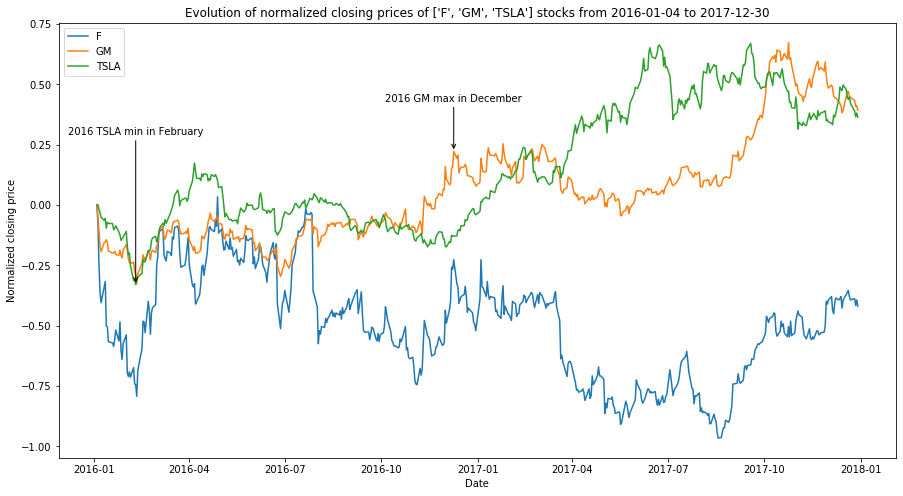

In [13]:
stock_list = ['F', 'GM','TSLA']
show_multiple_stocks(stock_list, '2016-01-04', '2017-12-30')